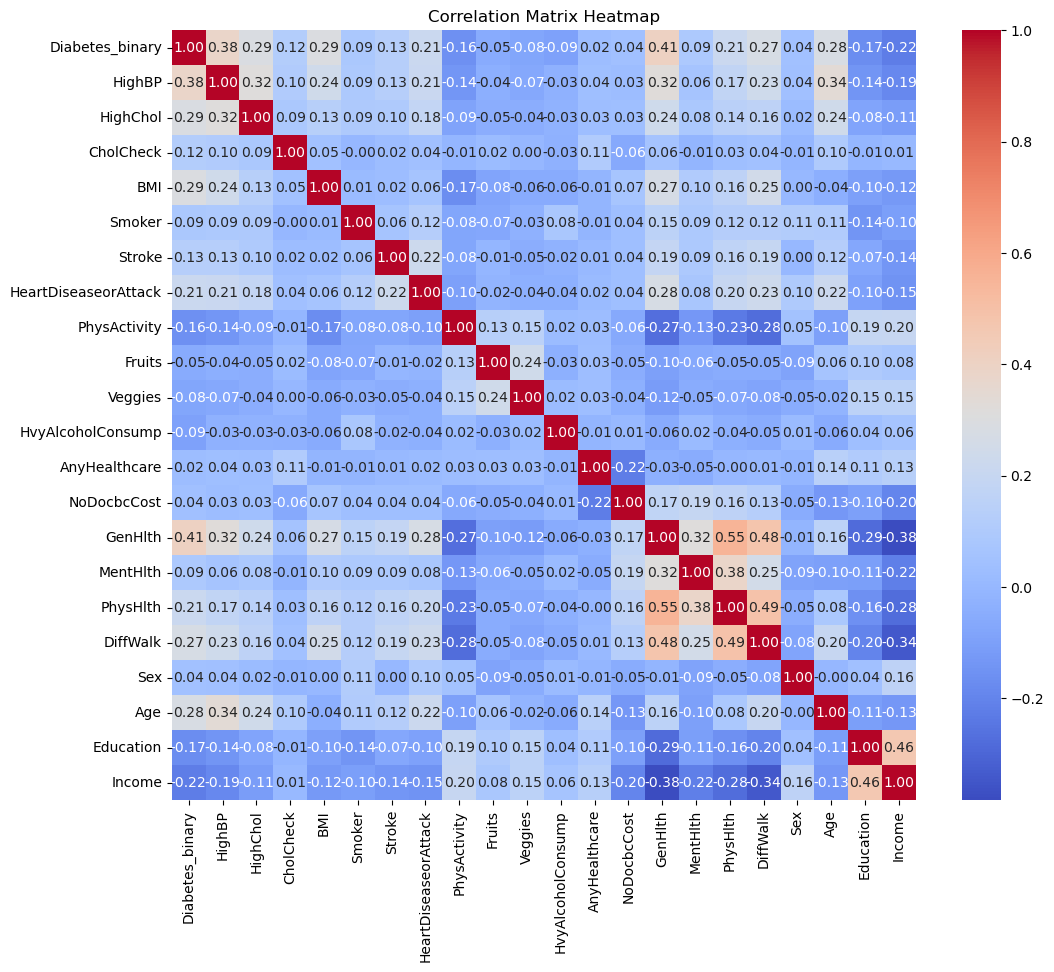

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('working_dir/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))  # Optional: Make plot bigger for readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [61]:
from sklearn.feature_selection import mutual_info_regression

print(mutual_info_regression(df["BMI"].to_numpy().reshape(-1, 1), df["GenHlth"].to_numpy()))
print(mutual_info_regression(df["GenHlth"].to_numpy().reshape(-1, 1), df["BMI"].to_numpy()))

[0.05503694]
[0.05142719]


In [46]:
# Step 1: Identify binary and continuous columns
binary_cols = [col for col in df.columns if sorted(df[col].dropna().unique()) == [0, 1]]
continuous_cols = [col for col in df.columns if col not in binary_cols and col != 'Diabetes_012']
print("Binary columns:", binary_cols)
print("Continuous columns:", continuous_cols)

# Step 2: Calculate Q1, Q2, Q3, IQR only for continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q2 = df[continuous_cols].quantile(0.50)  # Median
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

print("\nQ1:\n", Q1)
print("\nQ2 (Median):\n", Q2)
print("\nQ3:\n", Q3)
print("\nIQR:\n", IQR)

# Step 3: Remove outliers for continuous columns only
# (Binary columns are untouched)
filter_condition = ~((df[continuous_cols] < (Q1 - IQR)) | (df[continuous_cols] > (Q3 + IQR))).any(axis=1)
df_clean = df







print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)


Binary columns: ['0', '1']
Continuous columns: ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 'col']

Q1:
 2       0.000000
3       1.000000
4      28.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.547260
11      0.000000
12      1.000000
13      0.000000
14      2.384965
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      6.381460
20      4.000000
col     4.000000
Name: 0.25, dtype: float64

Q2 (Median):
 2       0.837783
3       1.000000
4      46.032868
5       0.402811
6       0.000000
7       0.000000
8       0.792069
9       0.752215
10      1.000000
11      0.000000
12      1.000000
13      0.000000
14      3.198566
15      0.000000
16      4.238743
17      0.307833
18      0.000000
19      8.000000
20      5.000000
col     5.000000
Name: 0.5, dtype: float64

Q3:
 2       1.000000
3       1.000000
4      57.450661
5       1.000000
6       0.0

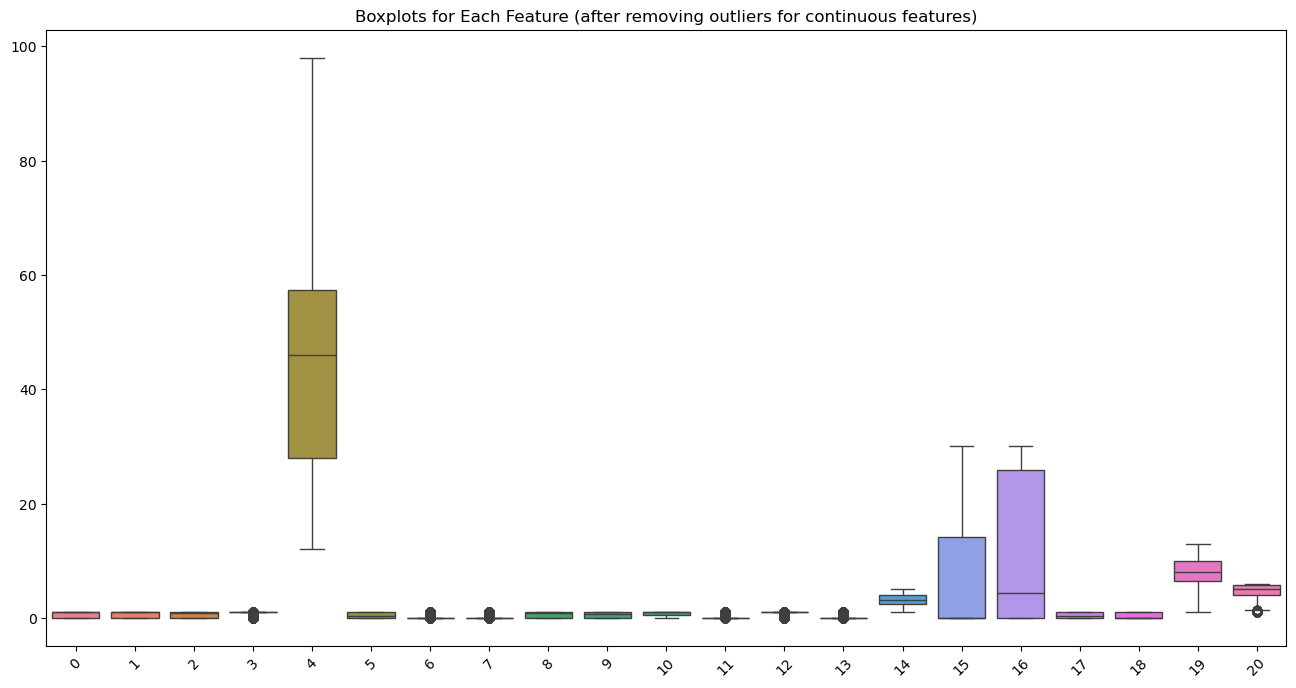

In [39]:
# Plot boxplots
plt.figure(figsize=(16, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title('Boxplots for Each Feature (after removing outliers for continuous features)')
plt.show()

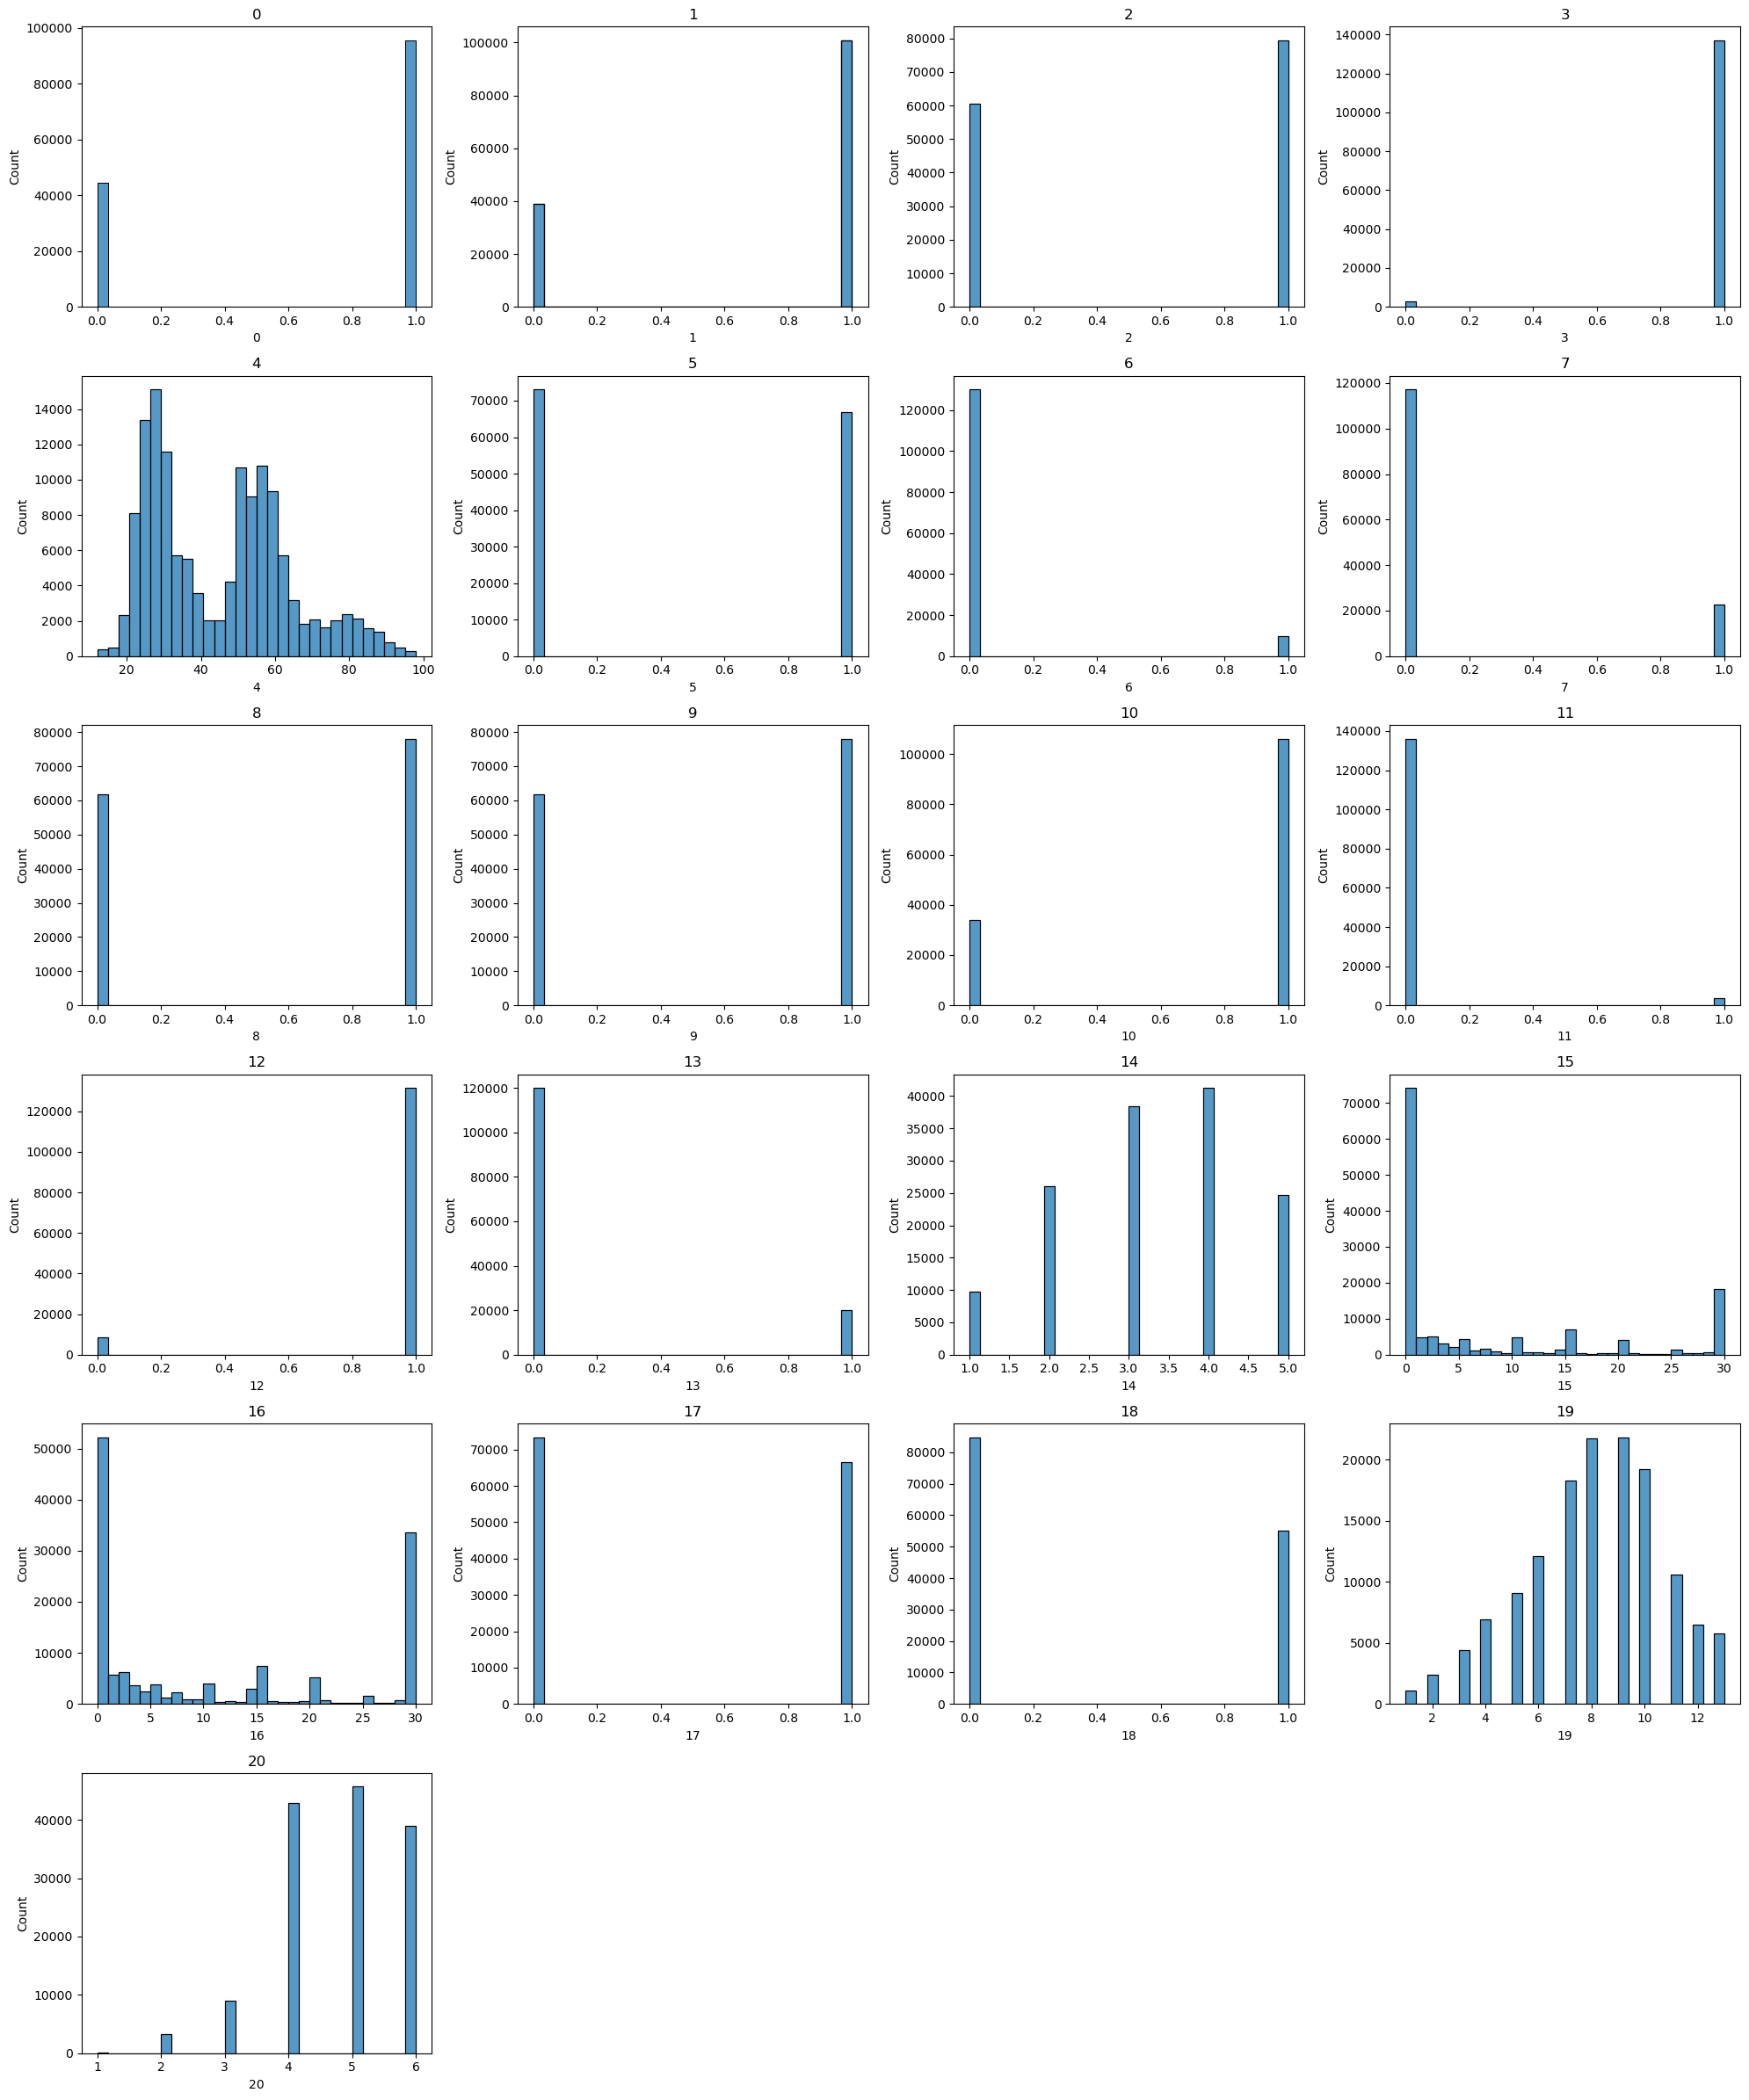

In [51]:
n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    plt.tight_layout()

plt.show()


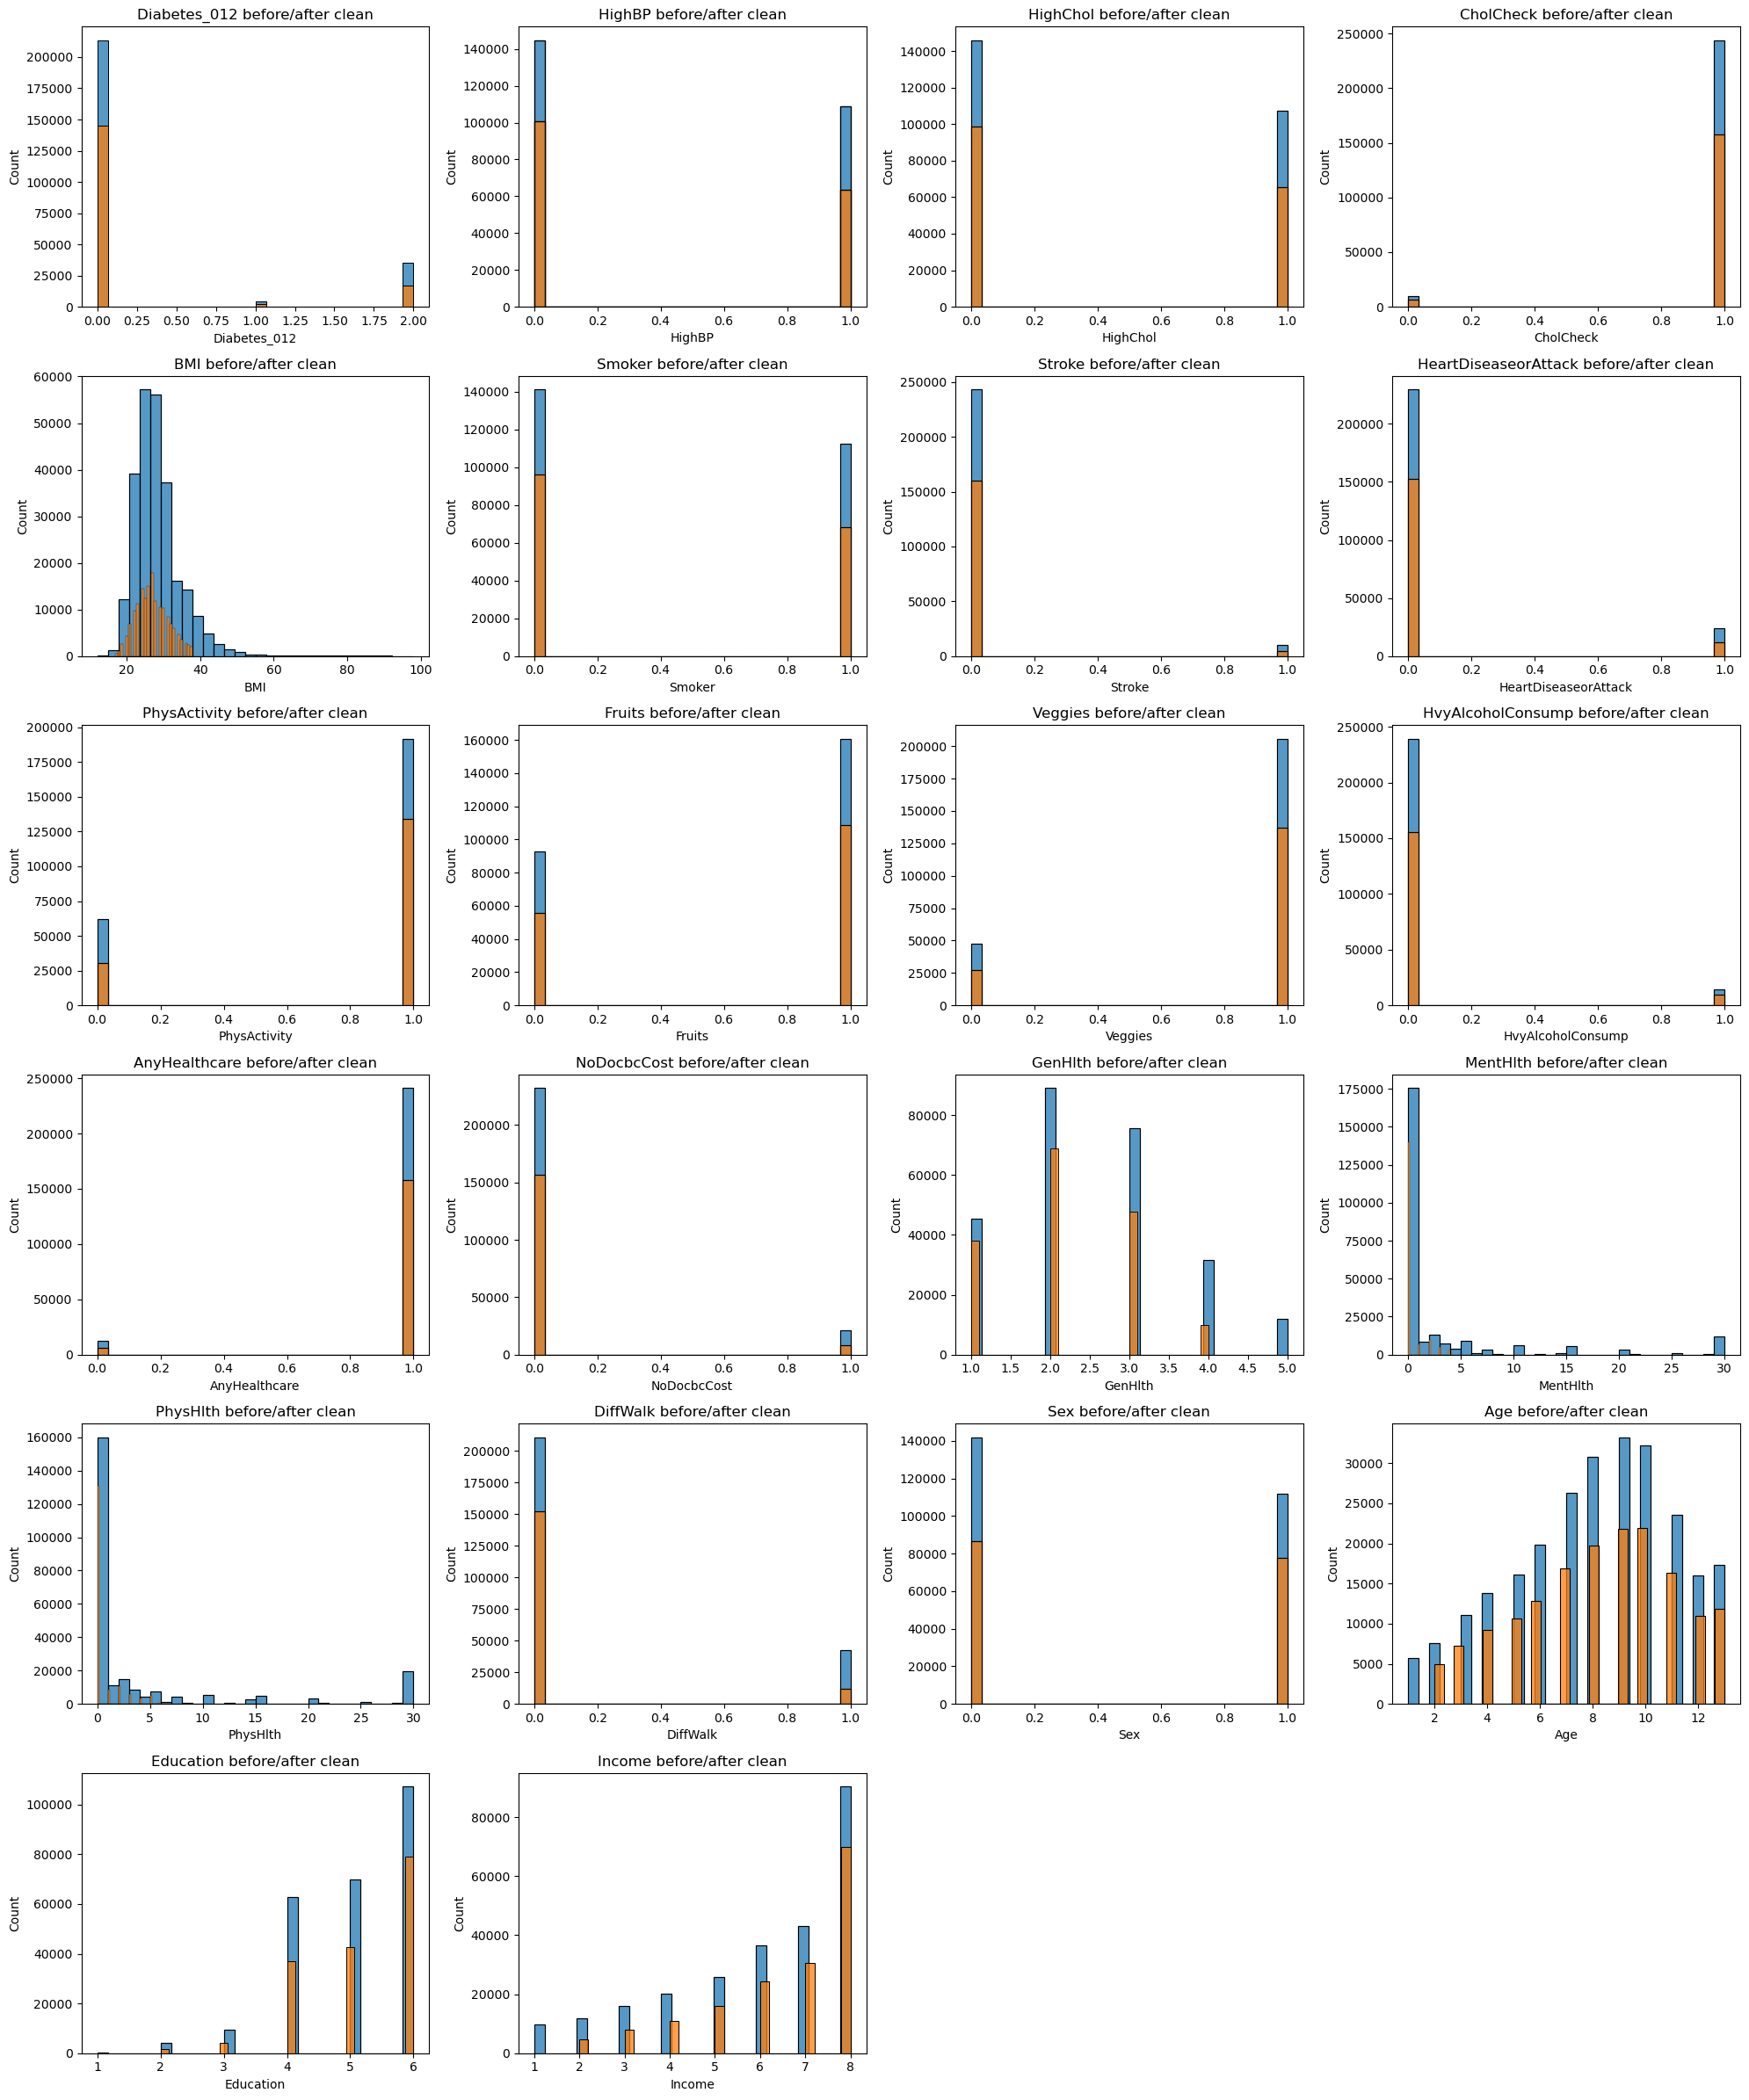

In [ ]:
n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)

    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_clean[col], bins=30, kde=False)
    plt.title(f"{col} before/after clean")

    plt.tight_layout()

plt.show()

In [ ]:
# save the cleaned data:

df_clean.to_csv('cleaned_diabetes.csv', index=False)


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


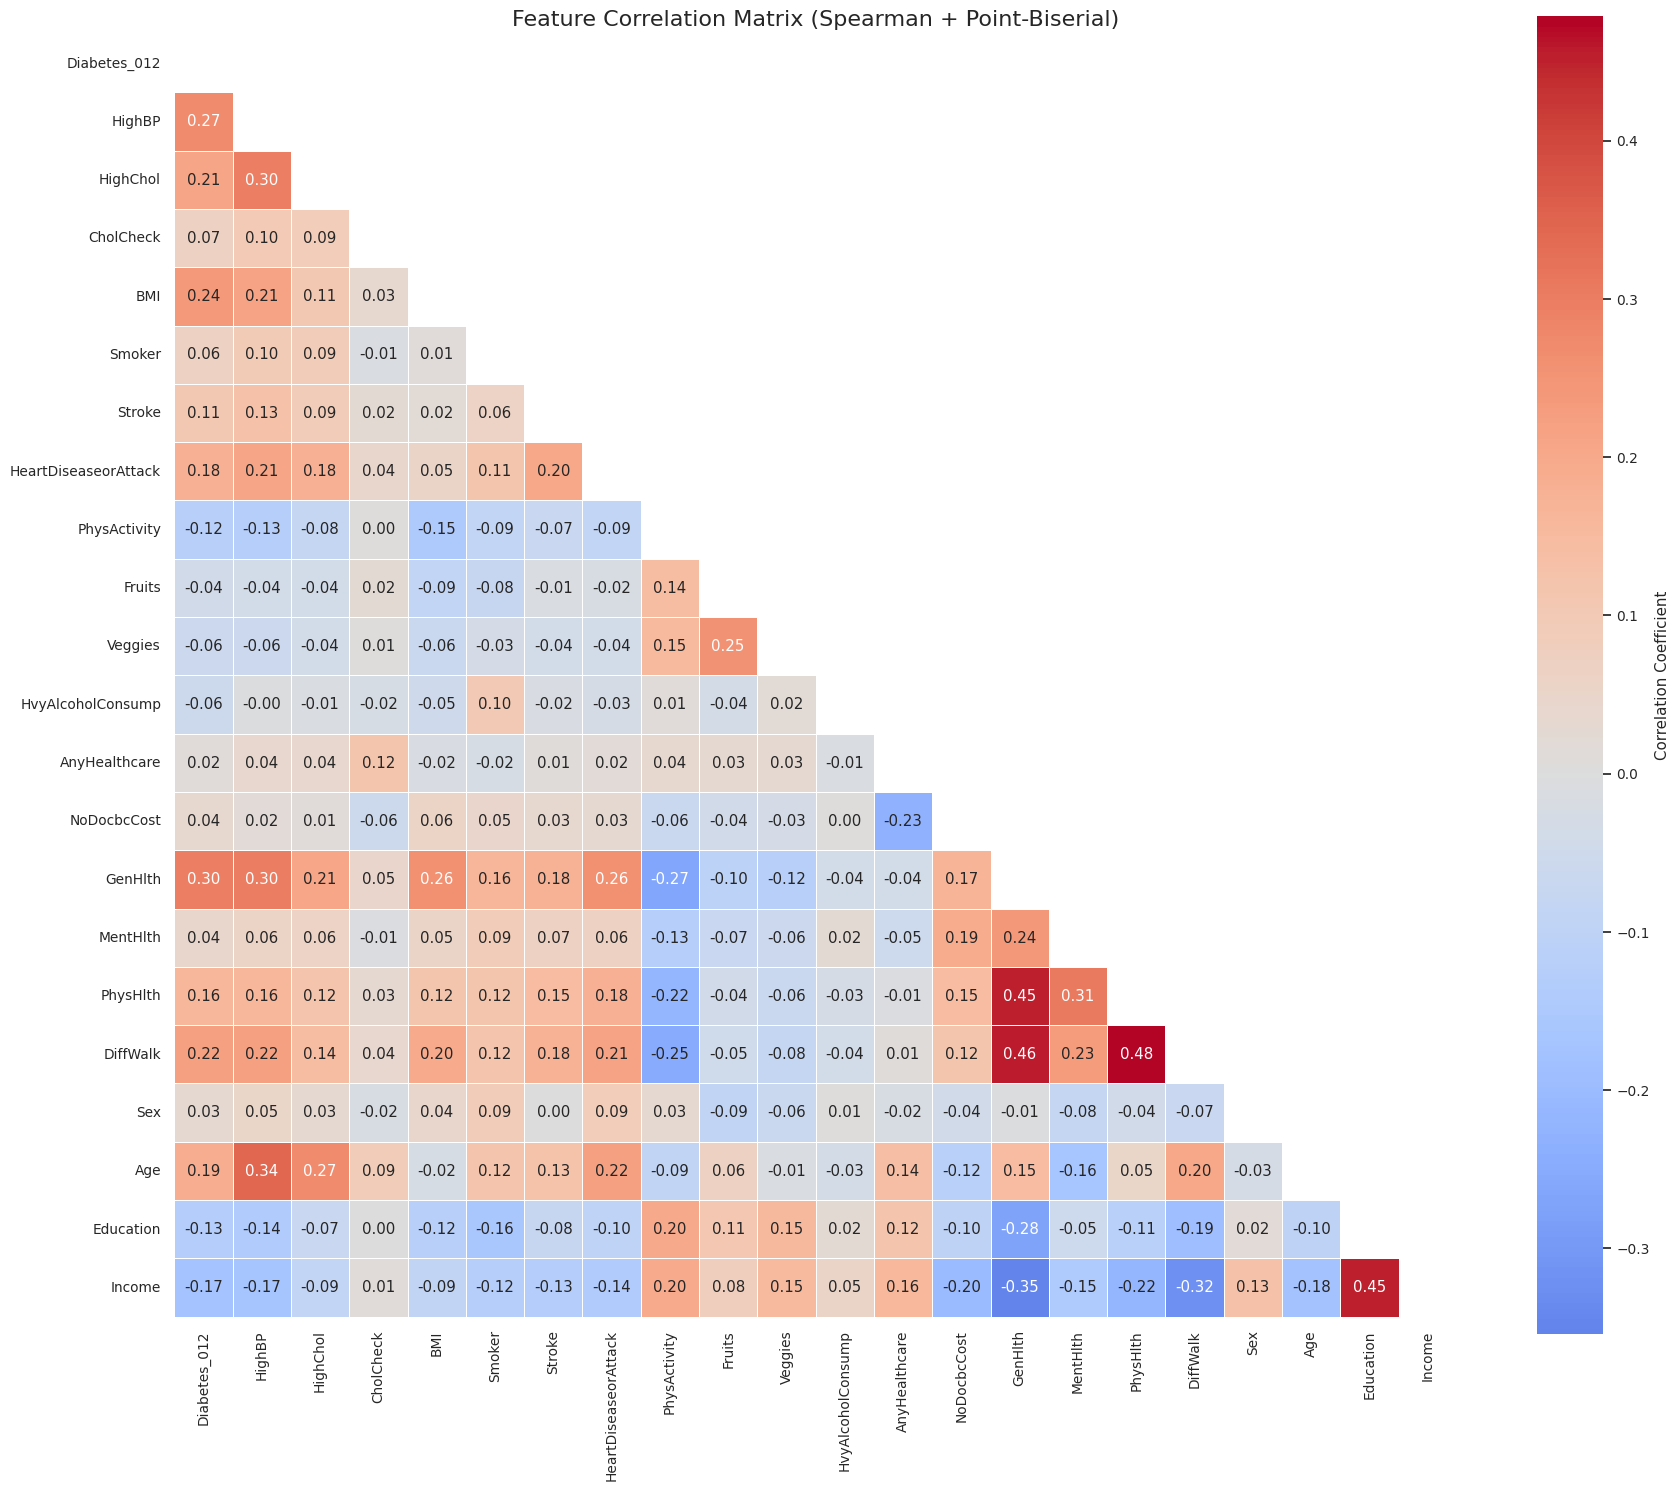


Top correlations with Diabetes_012:
Diabetes_012            1.000000
GenHlth                 0.297138
HighBP                  0.271596
BMI                     0.235887
DiffWalk                0.224239
HighChol                0.209085
Age                     0.186357
HeartDiseaseorAttack    0.180272
Income                 -0.172611
PhysHlth                0.161718
Name: Diabetes_012, dtype: float64


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, pointbiserialr, spearmanr
from tqdm import tqdm

# Load dataset
url = 'https://drive.google.com/uc?id=1qKlywkZUCyQkLYDFOs_T8YUaW-TG6mEb'
df = pd.read_csv(url)

# Detect binary columns
is_binary = {col: df[col].nunique() == 2 for col in df.columns}

# Initialize correlation matrix
corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

# Compute correlations (lower triangle only)
for i, col1 in enumerate(tqdm(df.columns)):
    for j, col2 in enumerate(df.columns[:i+1]):
        x = df[col1]
        y = df[col2]

        if col1 == col2:
            corr = 1.0
        else:
            try:
                if is_binary[col1] and is_binary[col2]:
                    corr = pearsonr(x, y)[0]  # Phi coefficient
                elif is_binary[col1]:
                    corr = pointbiserialr(y, x)[0]  # y must be continuous
                elif is_binary[col2]:
                    corr = pointbiserialr(x, y)[0]
                else:
                    corr = spearmanr(x, y)[0]  # Use Spearman for non-linear
            except:
                corr = np.nan

        # Fill symmetric entries
        corr_matrix.loc[col1, col2] = corr
        corr_matrix.loc[col2, col1] = corr

# Plotting
plt.figure(figsize=(18, 15))
sns.set(style="white", font_scale=0.9)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Correlation Coefficient"},
    mask=mask
)

plt.title("Feature Correlation Matrix (Spearman + Point-Biserial)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Target variable correlations
if 'Diabetes_012' in df.columns:
    target_corr = corr_matrix['Diabetes_012'].sort_values(key=abs, ascending=False)
    print("\nTop correlations with Diabetes_012:")
    print(target_corr.head(10))